<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Thick_Slice_Pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
import matplotlib
import os
import urllib
import pyabf
import scipy as sci

In [26]:
import urllib
response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py

In [40]:
to_import = ['Simple_ABF_tools.ipynb','Basic_Ephys.ipynb']
for f in to_import:
    git_link = 'https://raw.githubusercontent.com/dtabuena/EphysLib/main/'+f
    urllib.request.urlretrieve(git_link,f)
    %run $f

import urllib
response = urllib.request.urlretrieve('https://raw.githubusercontent.com/dtabuena/Resources/main/Matplotlib_Config/Load_FS6.py','Load_FS6.py')
%run Load_FS6.py

In [5]:
dataset = []

dataset = {'data_name': 'thick_slice',
           'data_source': r'C:\Users\dennis.tabuena\Gladstone Dropbox\Dennis Tabuena\0_Projects\_Ripple\Ripple_Recordings\2023_07_06',
           'file_naming_scheme': ['Rec_date','GenoType','Sex','Age','Slice_Dir','Slice_Num','Cell_num','Cell_Type'],
           }


import os

def get_abf_files(directory):
    abf_file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.abf'):
                abf_file_list.append(os.path.join(root, file))
    return abf_file_list

# Usage
abf_file_list = get_abf_files(dataset['data_source'])
print(abf_file_list)


['C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\0_Projects\\_Ripple\\Ripple_Recordings\\2023_07_06\\2023x07x06_E3KI_F_P525_s1x2_0000.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\0_Projects\\_Ripple\\Ripple_Recordings\\2023_07_06\\2023x07x06_E3KI_F_P525_s1x2_0001.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\0_Projects\\_Ripple\\Ripple_Recordings\\2023_07_06\\2023x07x06_E3KI_F_P525_s1x2_0002.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\0_Projects\\_Ripple\\Ripple_Recordings\\2023_07_06\\2023x07x06_E3KI_F_P525_s3x4_0000.abf', 'C:\\Users\\dennis.tabuena\\Gladstone Dropbox\\Dennis Tabuena\\0_Projects\\_Ripple\\Ripple_Recordings\\2023_07_06\\2023x07x06_E3KI_F_P525_s5x6_0000.abf']


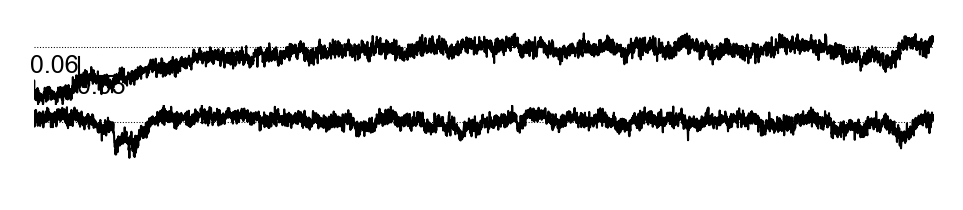

In [290]:
def plot_wrap_trace(trace,time,sample_rate,wrap_t,t_range=None,row_dim=[3,0.25],ylims=None,color='k',fig_ax=None,yticks=[0],scale=True):
    if t_range is not None:
        in_range = np.logical_and( time>=np.min(t_range), time<np.max(t_range) )
        trace = trace[in_range]
        time = time[in_range]
    if ylims is None:
        ylims = [np.min(trace),np.max(trace)]
    num_samples = len(time)
    len_wrap = int(wrap_t*sample_rate)
    num_rows = int(np.ceil(num_samples/len_wrap))
    wrapped_trace = np.full((num_rows, len_wrap), np.nan)
    wrapped_time = np.full((num_rows, len_wrap), np.nan)
    wrapped_trace.flat[:len(trace)] = trace
    wrapped_time.flat[:len(time)] = time


    if fig_ax is None:
        fig_dim = np.array(row_dim)*np.array((1,num_rows))
        fig,ax=plt.subplots(num_rows,1,figsize=fig_dim)
    else:
        [fig,ax] = fig_ax
    for r in range(num_rows):
        ax[r].plot(wrapped_time[r,:],wrapped_trace[r,:],color=color)
        ax[r].set_position([0,1-r/num_rows,1,1/num_rows])
        ax[r].set_ylim(ylims)
        ax[r].axis('off')
        ax[r].set_xlim([wrapped_time[r,0],wrapped_time[r,-1]])
        for y in yticks:
            wid = plt.rcParams['lines.linewidth']/2
            ax[r].axhline(y,color='k',linewidth=wid,linestyle='dotted')

    if scale:
        y_scale = log_round(np.diff(ylims)[0]/4)
        x_scale = wrap_t*.05
        x_0 = time[0]

        x0 = time[0] +x_scale
        x1 = time[0]+x_scale +x_scale
        y0 = -y_scale - y_scale*.5
        y1 = 0 - y_scale*.5

        scale_color = 'k'
        ax[0].plot([x0,x1],[y0,y0],color=scale_color)
        ax[0].plot([x0,x0],[y0,y1],color=scale_color)
        ax[0].text( (x0+x1)/2 , y0, str(x_scale), color=scale_color,ha='center',va='top')
        ax[0].text(x0 , (y0+y1)/2 , str(y_scale), color=scale_color,ha='right',va='center')
    return fig, ax

def log_round(x):
    lg = np.log10(x)
    lg_flr = np.floor(lg)
    x_rnd = np.round(x,int(-lg_flr))
    if lg>1:
        x_rnd=int(x_rnd)
    return x_rnd

_ = plot_wrap_trace(raw_lfp[:,0],time,sample_rate,wrap_t=1,t_range=[0,2])

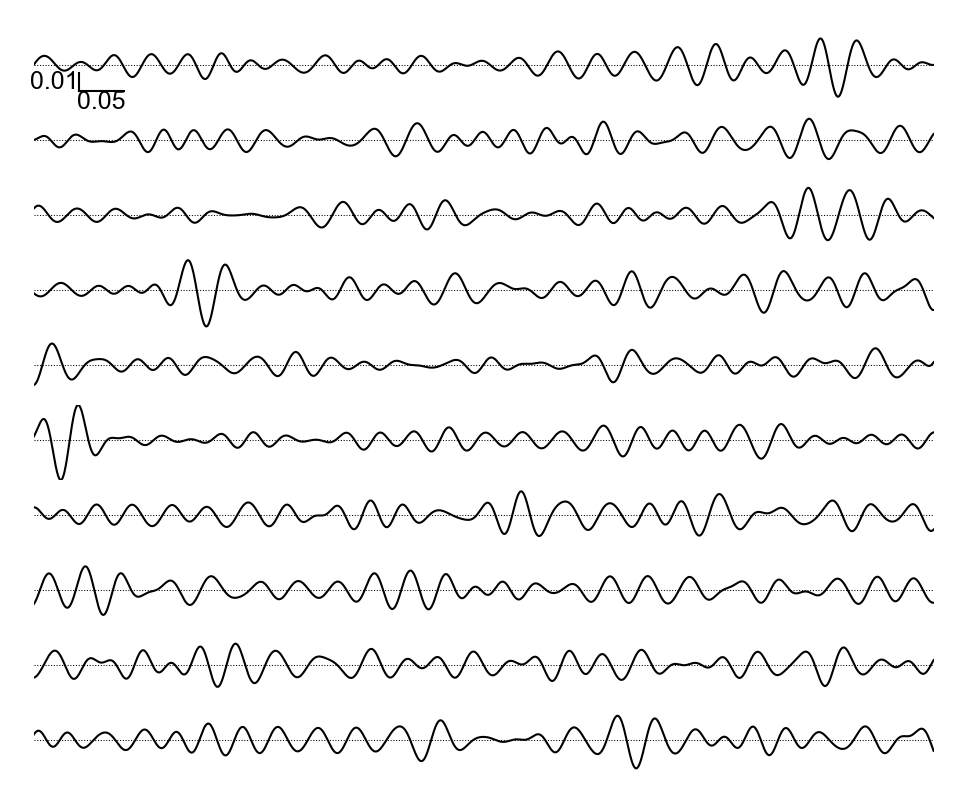

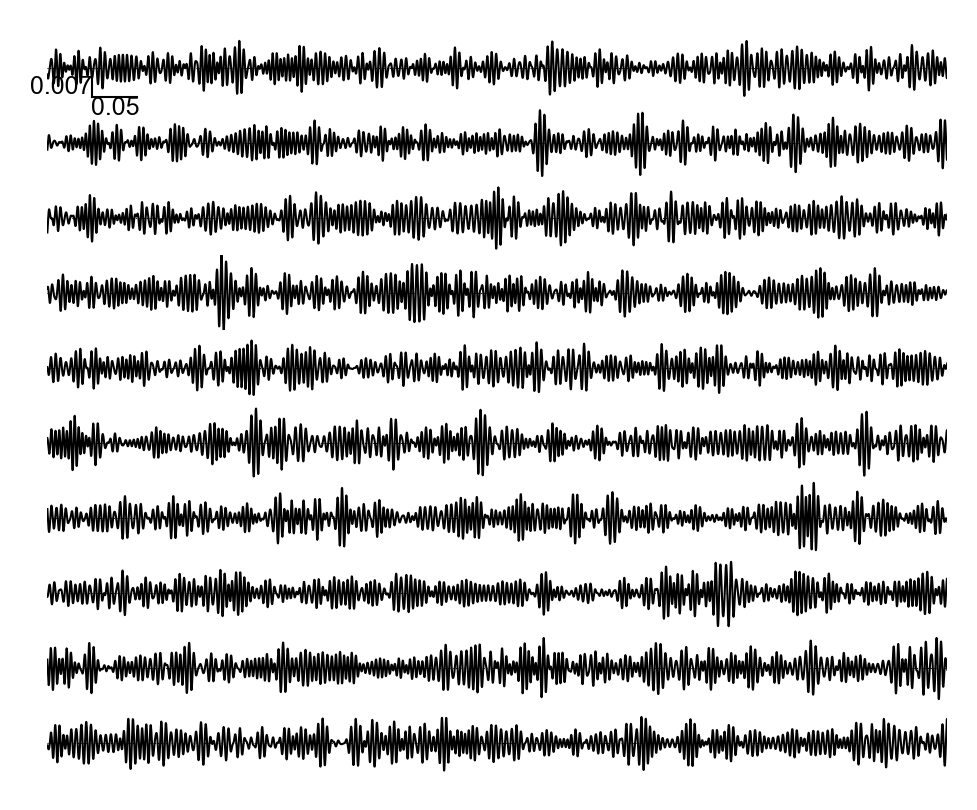

In [297]:
abf=pyabf.ABF(abf_file_list[0])

"""
Raw band
"""
wrap_t = 1
t_range = 120 + np.array([0, 10])

time = abf.sweepX
sample_rate=abf.sampleRate
raw_lfp = np.zeros((time.shape[0],len(abf.channelList)))
for ch in abf.channelList:
    abf.setSweep(0,channel=ch)
    raw_lfp[:,ch] = abf.sweepY
# _ = plot_wrap_trace(raw_lfp[:,0],time,sample_rate,wrap_t=wrap_t,t_range=t_range)

"""
Wide band
"""
nyquist = 0.5 * sample_rate
low = 0.1 / nyquist
high = 1000 / nyquist
b, a = sci.signal.butter(2, [low, high], btype='band')
wideband_lfp = sci.signal.filtfilt(b, a, raw_lfp, axis=0)
# _ = plot_wrap_trace(wideband_lfp[:,0],time,sample_rate,wrap_t=wrap_t,t_range=t_range)

"""
Slow Gamma band
"""
passband = np.array([15, 35])
width= 25
passband = passband #+ [-(width),width]
num_coefficients = 507
fir_coeff = sci.signal.firwin(num_coefficients, passband,width=width, window='hanning', pass_zero='bandpass', scale=True, fs=float(sample_rate))
slow_gamma_band = sci.signal.filtfilt(fir_coeff, 1.0, wideband_lfp, axis=0).astype('float16')
fig,ax = plot_wrap_trace(slow_gamma_band[:,0],time,sample_rate,wrap_t=1,t_range=t_range)


"""
Ripple band
"""
passband = np.array([150, 250]) #(150-250 Hz)
width= 25
passband = passband #+ [-(width),width]
num_coefficients = 507
fir_coeff = sci.signal.firwin(num_coefficients, passband,width=width, window='hanning', pass_zero='bandpass', scale=True, fs=float(sample_rate))
ripple_band = sci.signal.filtfilt(fir_coeff, 1.0, wideband_lfp, axis=0).astype('float16')

fig,ax =  plot_wrap_trace(ripple_band[:,0],time,sample_rate,wrap_t=1,t_range=t_range,color='k') # ,fig_ax=[fig,ax]


# ripple_env =  abs(sci.signal.hilbert(ripple_band,axis=0))
# _ = plot_wrap_trace(ripple_env[:,0],time,sample_rate,wrap_t=1,t_range=t_range,fig_ax=[fig,ax],color='r',ylims=[-.015,.015],yticks=[3])


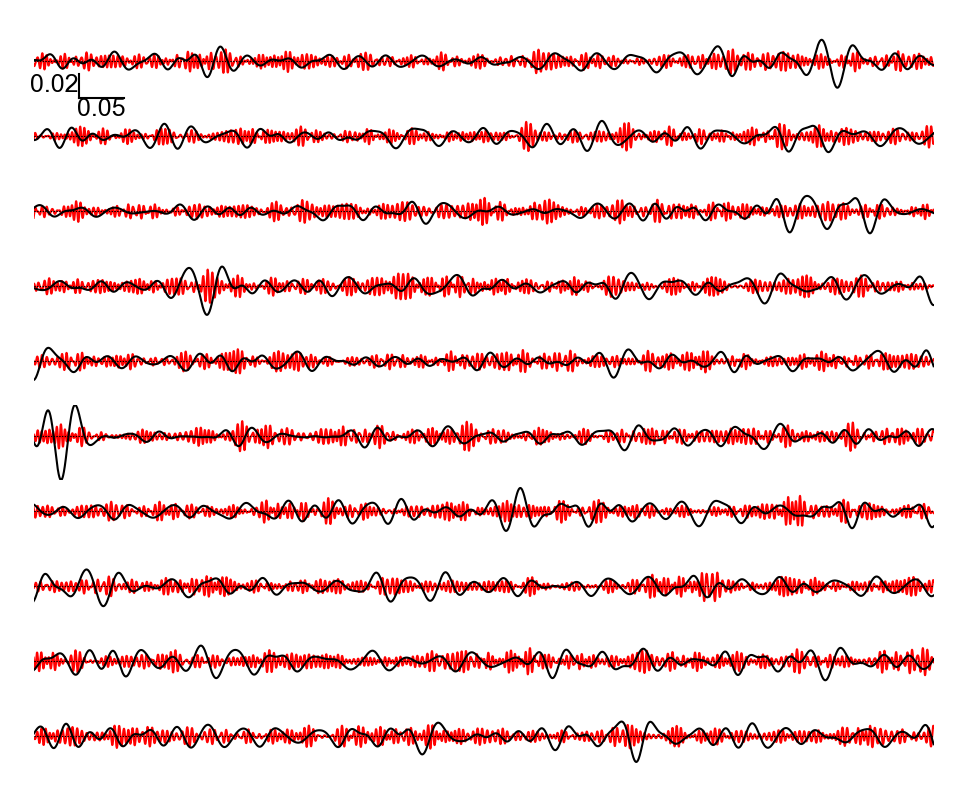

In [293]:
fig,ax = plot_wrap_trace(ripple_band[:,0],time,sample_rate,wrap_t=1,t_range=t_range,color='r',scale=False) # ,fig_ax=[fig,ax]
fig,ax = plot_wrap_trace(slow_gamma_band[:,0],time,sample_rate,wrap_t=1,t_range=t_range,fig_ax=[fig,ax])


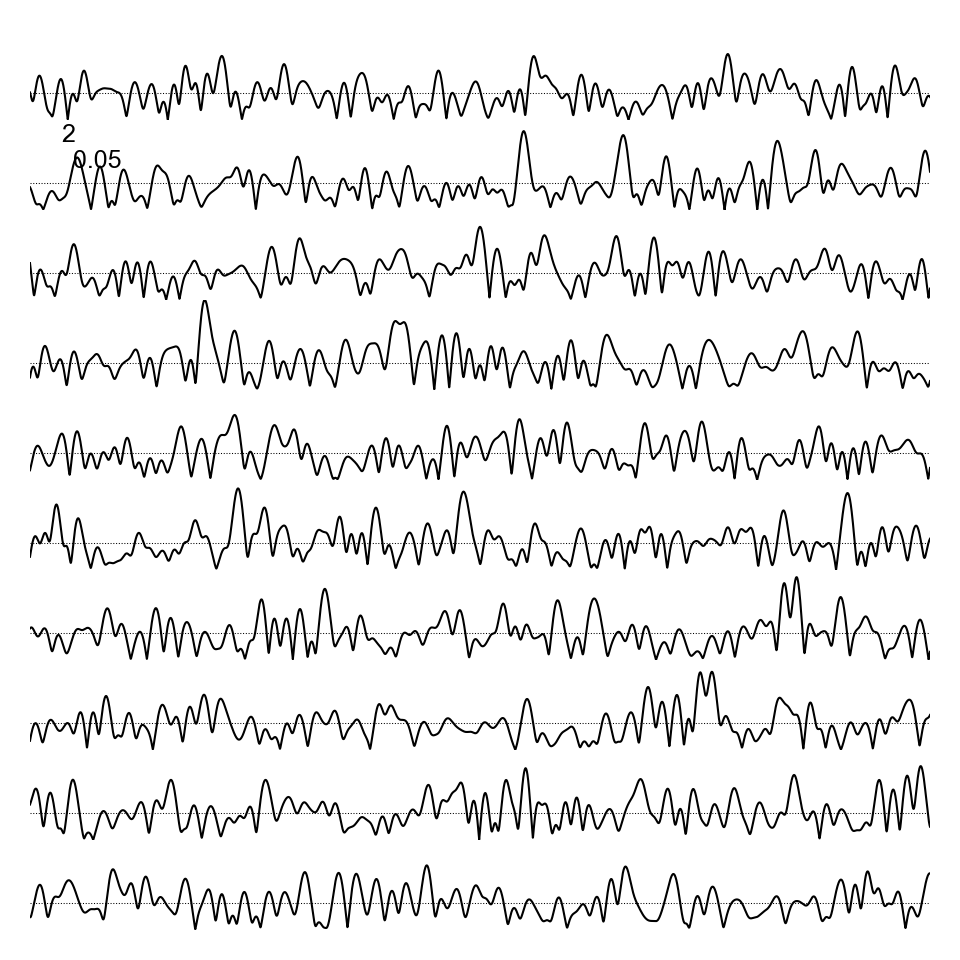

In [268]:

ripple_env_z = (ripple_env - np.mean(ripple_env,axis=0)) / np.std(ripple_env,axis=0)
_ = plot_wrap_trace(ripple_env_z[:,0],time,sample_rate,wrap_t=1,t_range=t_range)
